In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


In [2]:
#export 
import torch.nn.functional as F
import torch.nn as nn
from torchvision import models
from torch import optim
from torch.autograd import Variable
from sklearn import metrics
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.utils.data as data
import PIL
from scipy.ndimage import rotate, map_coordinates, gaussian_filter, zoom
from scipy.optimize import curve_fit
from torchvision import transforms
from functools import partial
import math
import random
import torchvision.transforms.functional as F1
import warnings
from PIL import Image
warnings.filterwarnings('ignore', '.*output shape of zoom.*')

In [3]:
INPUT_DIM = 64
MAX_PIXEL_VAL = 255


In [4]:
#export
def get_data(pathDir,pathCsv):
    dataPath,labels=[],[]
    for i, line in enumerate(open(pathCsv).readlines()):
        line = line.strip().split(',')
        dataPath.append(f'{pathDir}/{line[0]}.npy')
        labels.append(int(line[1]))
    return dataPath,labels

In [5]:
torch.cuda.device(0)
torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla P4'

In [6]:
torch.cuda.is_available()

True

In [7]:
#export
def subplots(rows, cols, imgsize=4, figsize=(3,3), title=None):
    "Like `plt.subplots` but with consistent axs shape, `kwargs` passed to `fig.suptitle` with `title`"
    fig, axs = plt.subplots(rows,cols,figsize=figsize)
    if rows==cols==1: axs = [[axs]] # subplots(1,1) returns Axes, not [Axes]
    elif (rows==1 and cols!=1) or (cols==1 and rows!=1): axs = [axs]
    #if title is not None: fig.suptitle(title)
    fig.suptitle(title)
    
    return axs

In [8]:
#export
def show_batch(dl):
    xs,ys = next(iter(dl))
    xs = (xs - xs.min()) / (xs.max() - xs.min())
    xs = xs[0,...]
    xs = xs.squeeze()
    totalImages = xs.shape[0]
    print (xs.shape, totalImages)
    totalImagesCols = 4
    totalImagesRows =totalImages//totalImagesCols     
    axs = subplots(totalImagesRows, totalImagesCols, imgsize=4, figsize=(4*totalImagesCols,3*totalImagesRows),title=ys.data.numpy()[0])
    for imgIndex,ax in zip(range(totalImages),axs.flatten()):
        disp = xs[imgIndex,...].numpy()
        #disp = disp.permute(1,2,0).numpy()
        ax.imshow(disp,cmap='gray')
    plt.tight_layout()

In [9]:
p = Path('/home/jupyter/tutorials/data/MRNet-v1.0')
pathcsv = Path('.')

In [10]:
paths,labels = get_data(f'{p}/train/axial', f'{pathcsv}/train-abnormal.csv')

In [11]:
total_training_data = len(paths)

In [12]:
total_training_data
mean_vol = 0.00
std_vol = 0.00
MEAN= 0.
for idx in range(len(paths)):
    vol =np.load(paths[idx])
    #print(vol.shape[0])
    mean_vol += np.mean(vol)
    std_vol += np.std(vol)

MEAN = mean_vol/(total_training_data*MAX_PIXEL_VAL)
STDDEV  = std_vol/(total_training_data*MAX_PIXEL_VAL)

print (f'Average Mean and Standard Dev of all volumes  are {MEAN} and {STDDEV}')

Average Mean and Standard Dev of all volumes  are 0.24788097338806328 and 0.23716910007215272


In [13]:
numClasses = np.array(labels).max()+1
numClasses

2

In [14]:
#export
class Normalize:
    def __init__(self,MEAN,STD,  **kwargs):
        self.Mean, self.STD = MEAN, STD
    def __call__(self,m):   
        m = (m - self.Mean) / self.STD
        return  m

In [15]:
class RandomAffineVol:
    def __init__(self, degrees,  translate=None, scale=None, shear=None, resample=False, fillcolor=0):
        self.degrees = degrees
        self.translate = translate
        self.scale = scale
        self.shear= .0
        self.resample = resample
        self.fillcolor = fillcolor
        
        
    @staticmethod
    def get_params(degrees,translate, scale_ranges, img_size ):
       
        angle = random.uniform(degrees[0], degrees[1])
        max_dx = translate[0] * img_size[0]
        max_dy = translate[1] * img_size[1]
        translations = (np.round(random.uniform(-max_dx, max_dx)),np.round(random.uniform(-max_dy, max_dy)))
        
        if scale_ranges is not None:
            scale = random.uniform(scale_ranges[0], scale_ranges[1])
        else:
            scale = 1.0

        
        return angle,translations,scale
  
    def __call__(self, m):
        
        ret = self.get_params(self.degrees,self.translate,self.scale,[m[0].size[-1],m[0].size[-2]])  
        
        return [F1.affine(m[c], *ret, self.shear, self.resample, self.fillcolor ) for c in range(len(m))]
       

In [16]:
class RandomFlipVol:
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, m):
        """
        Args:
            img (PIL Image): Image to be flipped.

        Returns:
            PIL Image: Randomly flipped image.
        """
        if random.random() < self.p:
            return [F1.hflip(m[c]) for c in range(len(m))]
            
        return m


In [17]:
class ResizeVol:
    def __init__(self, size, interpolation=PIL.Image.BILINEAR):
        assert isinstance(size, int) or (isinstance(size, Iterable) and len(size) == 2)
        self.size = size
        self.interpolation = interpolation
    
    def __call__(self, m):
        """
        Args:
            img (PIL Image): Image to be scaled.

        Returns:
            PIL Image: Rescaled image.
        """
       
        return [F1.resize(m[c], self.size, self.interpolation ) for c in range(len(m))]
       

In [18]:
#export
class ToPIL:  
    def __init__(self, mode=None):
        self.mode = 3
        
    def __call__(self, m):  
        toPIL = transforms.ToPILImage() 
        #PILslices = [toPIL(m[c]) for c in range(m.shape[0])]      
        PILslicesTemp= [Image.fromarray(m[c]) for c in range(m.shape[0])]
        PILslices= [PILslicesTemp[c].convert('L') for c in range(len(PILslicesTemp))]
        return PILslices

In [19]:
#export
class ToTensor:  
    def __init__(self, mode=None):
        self.mode = 3
        
    def __call__(self, m):  
        toTensor = transforms.ToTensor() 
        TensorList = [torch.squeeze(toTensor(m[c].convert("L")) )for c in range(len(m))]
        mT = torch.stack(TensorList)
        mT = mT[None,...]
        return (mT)

In [20]:
#export
class Dataset(data.Dataset):
    def __init__(self,pathDir,pathCsv,transform=None):
        super().__init__()
        self.paths,self.labels = get_data(pathDir, pathCsv)
        self.transform = transform
        self.maxSlices = 50
        
    def __getitem__(self,index):
        path = self.paths[index]
        vol =np.load(path)
        vol= np.uint8(vol)
        if (vol.shape[0] >= self.maxSlices):    
            vol_temp = vol[(vol.shape[0]//2) - (self.maxSlices//2): (vol.shape[0]//2) + (self.maxSlices//2)]
        else:    
            pad = self.maxSlices  - vol.shape[0]
            #startSlice = torch.LongTensor(1).random_(0, max(pad//2,1) )
            #print(self.maxSlices, vol.shape[0],pad,startSlice[0])
            vol_temp = np.zeros((self.maxSlices,vol.shape[1], vol.shape[2])).astype(np.uint8)
            vol_temp[pad//2 : pad//2+vol.shape[0],:,:] = vol
            #print (vol.shape[0],vol.shape[1], vol.shape[2], pad, vol_temp.shape)
        
        vol = vol_temp
       

        if self.transform :
            vol_tensor = self.transform(vol)
        
        label_tensor = torch.tensor(self.labels[index])
        return vol_tensor, label_tensor

    def __len__(self):
        return len(self.paths)
    


In [21]:
transform_train = transforms.Compose([ToPIL(),RandomAffineVol([-25,25],[0.15,0.15],[0.9,1.1]),RandomFlipVol(0.5),ResizeVol(INPUT_DIM),ToTensor(), Normalize(MEAN,STDDEV)])
transform_tuneVal = transforms.Compose([ToPIL(),ResizeVol(INPUT_DIM), ToTensor(), Normalize(MEAN,STDDEV)])

In [22]:
train_dataset = Dataset(f'{p}/train/coronal', f'{pathcsv}/train-abnormal_fake0.csv',transform_train)
tuning_dataset = Dataset(f'{p}/train/coronal', f'{pathcsv}/training-tuning-abnormal.csv', transform_tuneVal)
valid_dataset = Dataset(f'{p}/valid/coronal', f'{pathcsv}/valid-abnormal.csv', transform_tuneVal)


In [23]:
train_dataset[0][1]

tensor(1)

In [24]:
len(train_dataset),len(tuning_dataset), len(valid_dataset)

(1676, 120, 120)

In [25]:
train_dataset[0][0].shape

torch.Size([1, 50, 64, 64])

In [26]:
train_dataset[0][1]

tensor(1)

In [27]:
#export
def get_dls(train_ds, tuning_ds, valid_ds, bs=32, **kwargs):
    return (data.DataLoader(train_ds, batch_size=bs, num_workers=8,shuffle=True, **kwargs),
            data.DataLoader(tuning_ds, batch_size=2*bs, num_workers=8,**kwargs),
            data.DataLoader(valid_ds, batch_size=2*bs, num_workers=8,**kwargs))


In [28]:
train_dl, tuning_dl, valid_dl = get_dls(train_dataset,tuning_dataset, valid_dataset,bs=4)

In [29]:
#export
class DataBunch():
    def __init__(self, train_dl, tuning_dl,valid_dl, c=None):
        self.train_dl,self.tuning_dl, self.valid_dl,self.c = train_dl,tuning_dl, valid_dl,c
     
    @property
    def train_ds(self): return self.train_dl.dataset
    
    @property
    def tuning_ds(self): return self.tuning_dl.dataset
        
    @property
    def valid_ds(self): return self.valid_dl.dataset

In [30]:
Data = DataBunch(*get_dls(train_dataset, tuning_dataset, valid_dataset, bs=20), c=numClasses)

In [31]:
xs,ys = next(iter(train_dl))

torch.Size([50, 64, 64]) 50


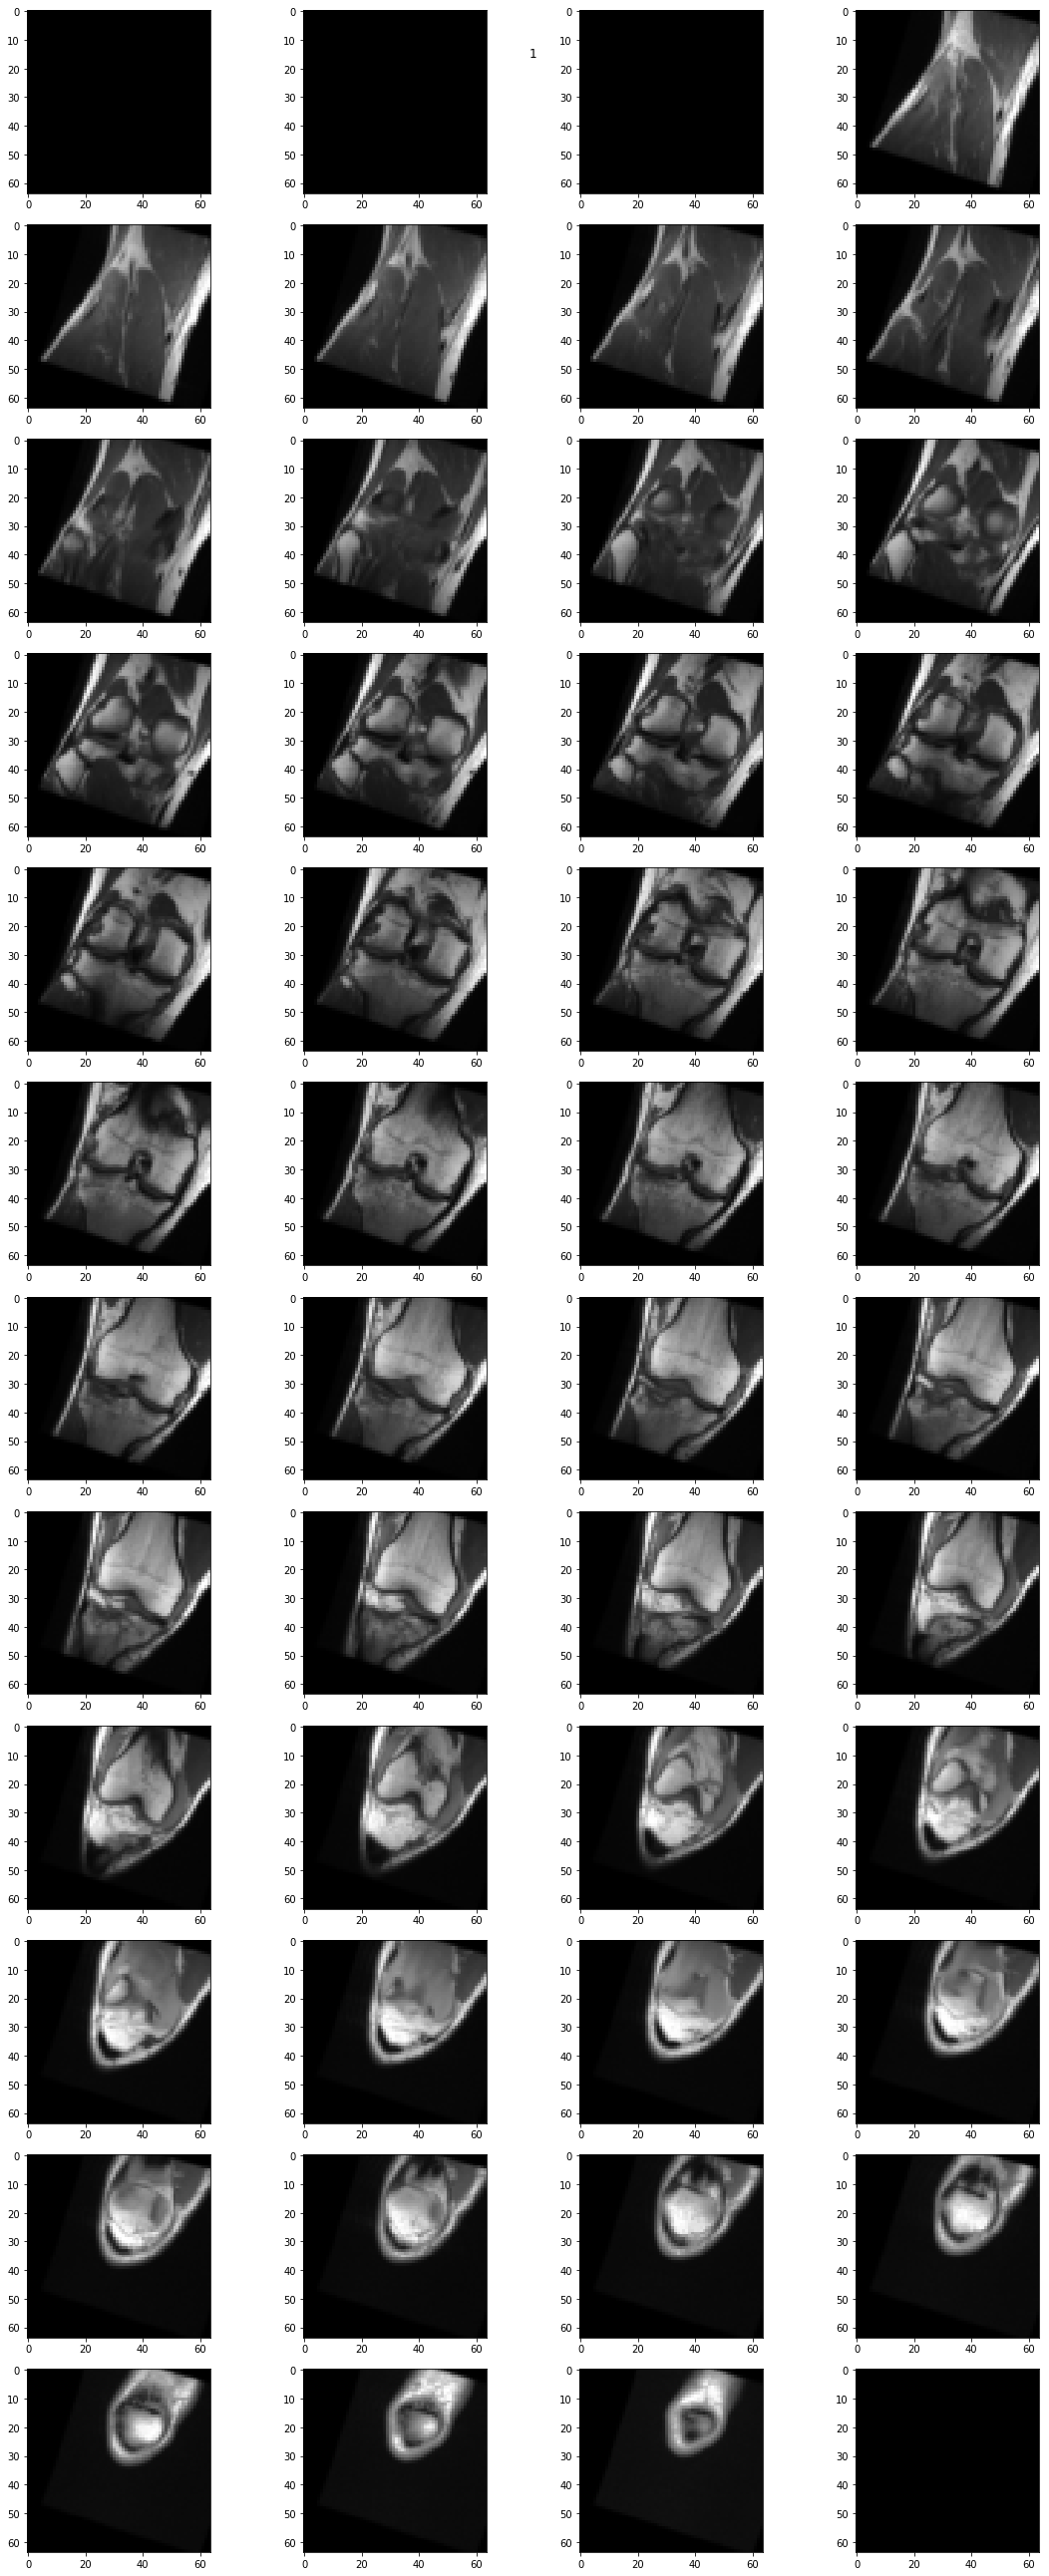

In [32]:
show_batch(train_dl)

torch.Size([50, 64, 64]) 50


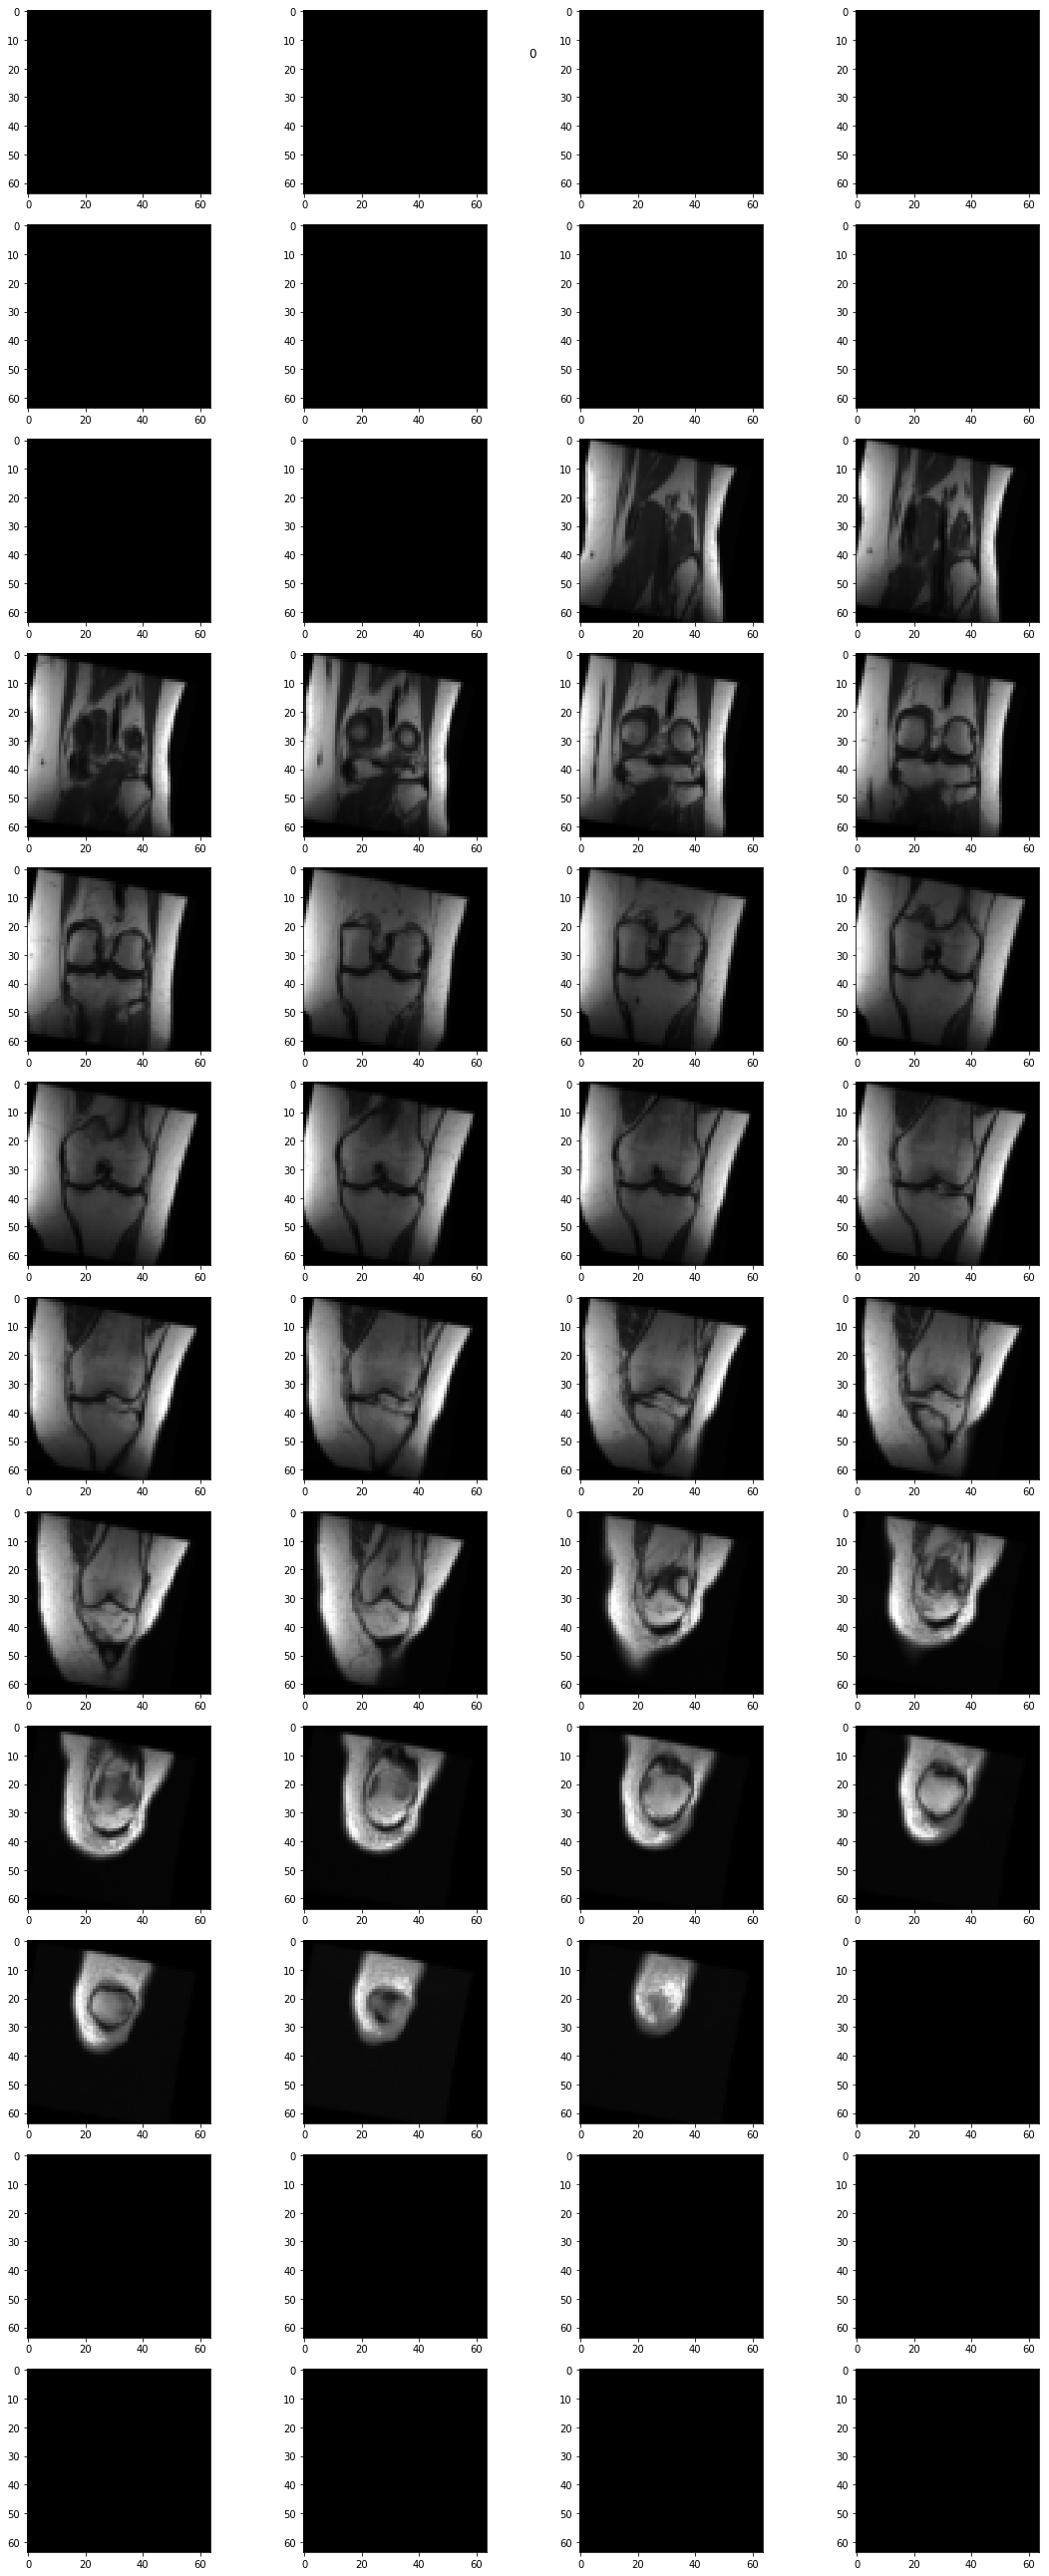

In [33]:
show_batch(train_dl)

torch.Size([50, 64, 64]) 50


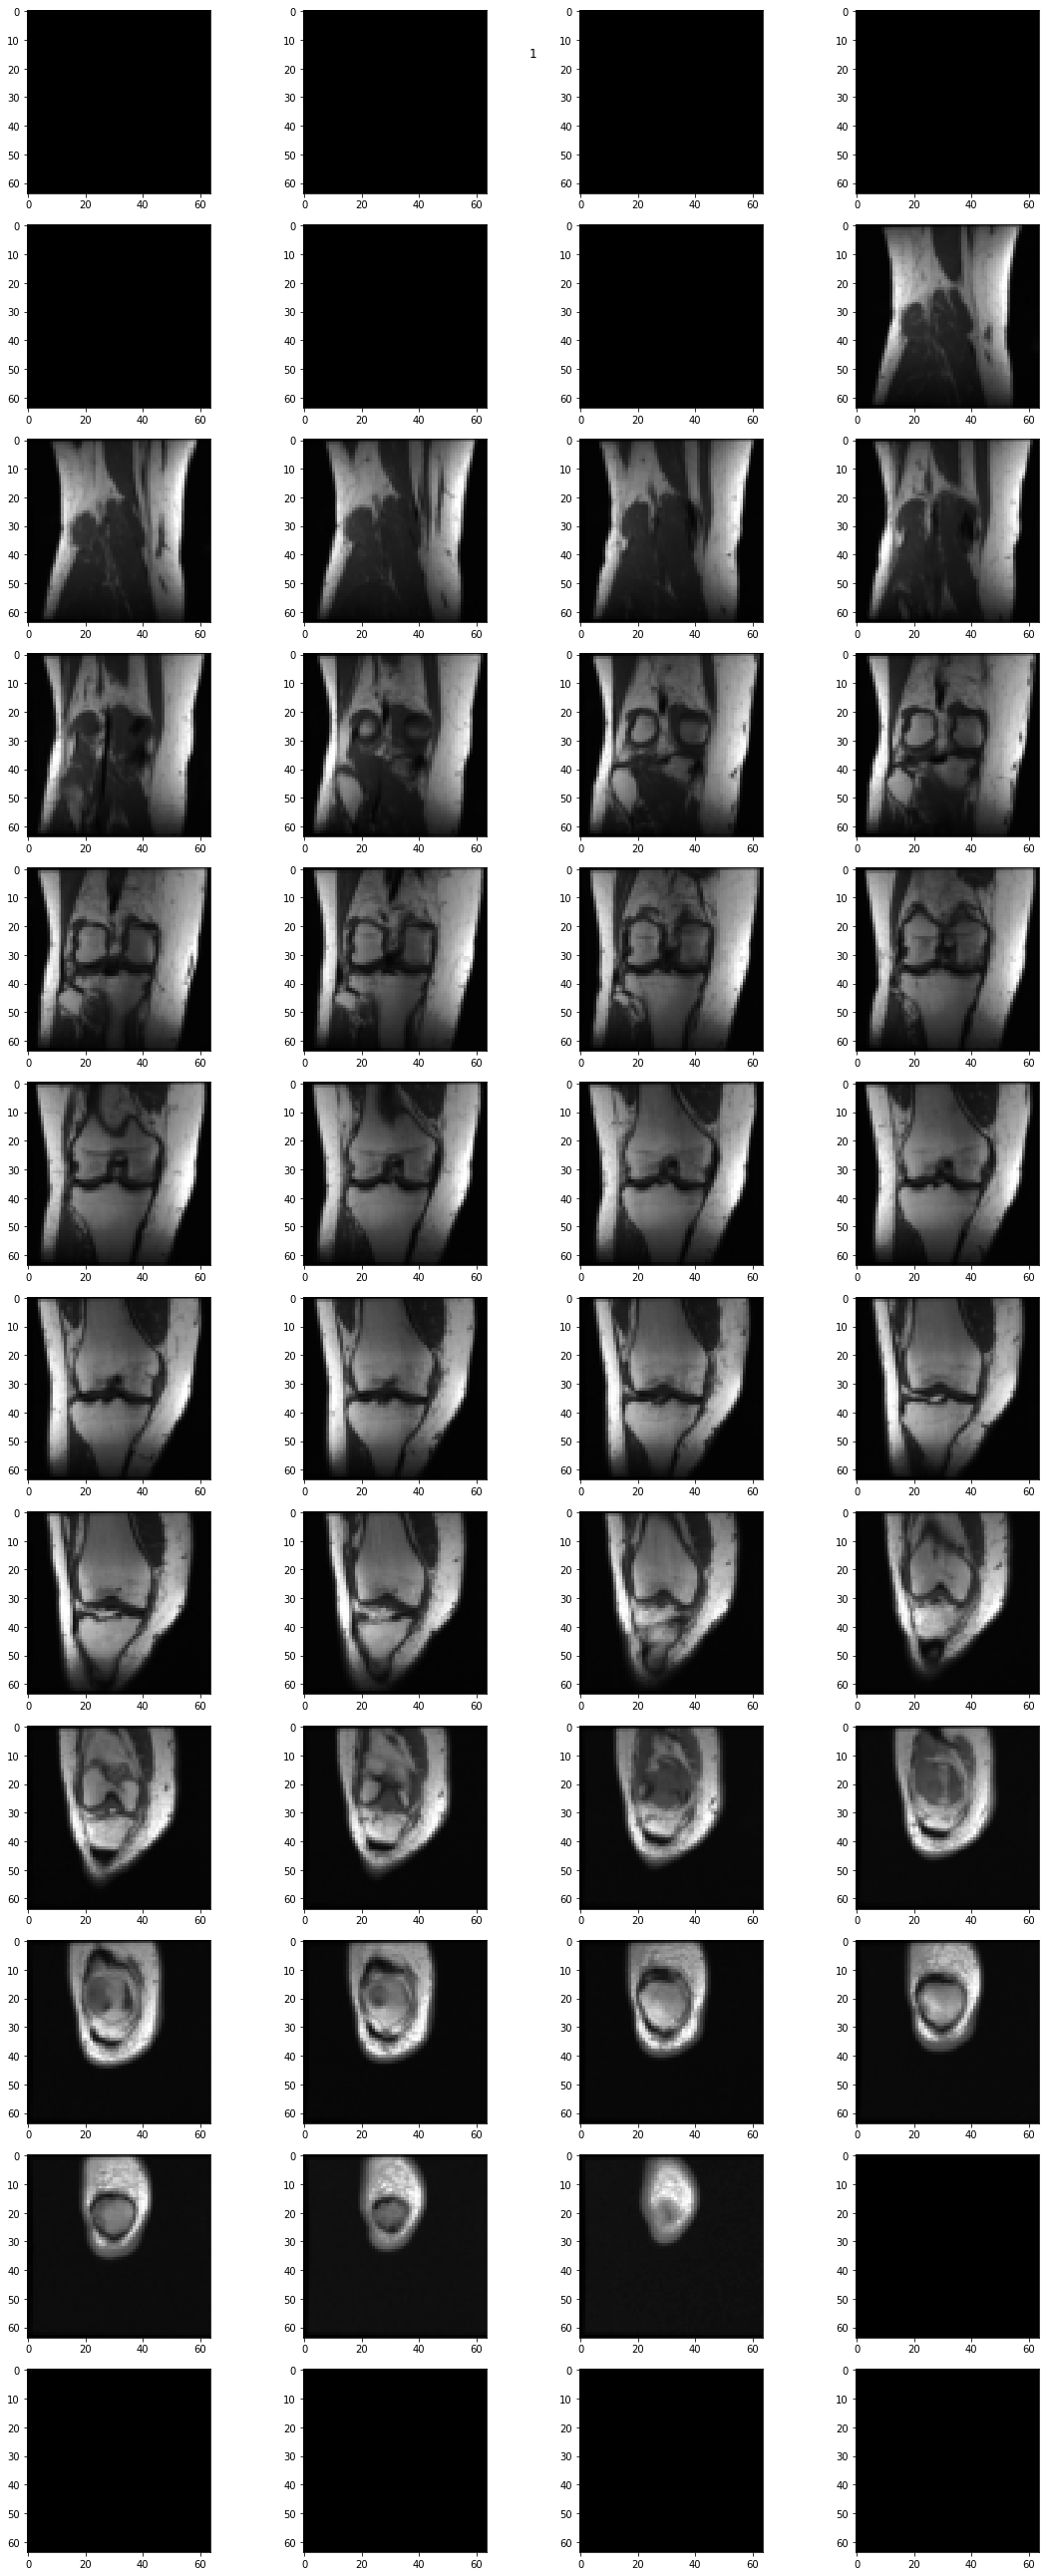

In [34]:
show_batch(tuning_dl)

In [35]:
xs.mean(), xs.std()

(tensor(-0.5472), tensor(0.8844))

In [36]:
xs.shape

torch.Size([4, 1, 50, 64, 64])

In [37]:
xb,yb = next(iter(Data.train_dl))

In [38]:
xb.mean(), xb.std()

(tensor(-0.4119), tensor(0.9424))

In [39]:
len(Data.train_dl), len(Data.valid_dl),len(Data.tuning_dl)

(84, 3, 3)

In [40]:
xb.shape

torch.Size([20, 1, 50, 64, 64])

In [41]:
yb.shape,yb

(torch.Size([20]),
 tensor([0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0]))

In [42]:
xb.shape,yb.shape

(torch.Size([20, 1, 50, 64, 64]), torch.Size([20]))

In [43]:

    
class fcLayer(nn.Module):
    
    def __init__(self,inC, outC):
        super().__init__()
        
        
        self.fc1 = nn.Linear(inC, 1024)
        self.fc2 = nn.Linear(1024, outC)
        self.dp  = nn.Dropout(0.8)
        
        torch.nn.init.xavier_normal_(self.fc1.weight)
        self.fc1.bias.data.fill_(0)
        torch.nn.init.xavier_normal_(self.fc2.weight)
        self.fc2.bias.data.fill_(0)
    
    def forward(self,x):
        return self.fc2(self.dp(self.fc1(x)))



class convLayer(nn.Module):
    
    def __init__(self,inC, outC, kernel_size,stride, padding,bias):
        super().__init__()
        self.conv = nn.Conv3d(inC,outC,kernel_size,stride,padding,bias) 
        torch.nn.init.xavier_normal_(self.conv.weight)
        self.conv.bias.data.fill_(0)    
    
    def forward(self,x):
        return self.conv(x)
        
    
class convLayerBn(nn.Module):
    
    def __init__(self,inC, outC, kernel_size,stride, padding,bias):
        super().__init__()
        self.conv = nn.Conv3d(inC,outC,kernel_size,stride,padding,bias=False) 
        torch.nn.init.xavier_normal_(self.conv.weight)
        self.bn = nn.BatchNorm3d(outC)
        self.relu = nn.LeakyReLU(negative_slope=0.1, inplace=True)
    def forward(self,x):
        return( self.relu(self.bn(self.conv(x))))
    
    
class resLayer(nn.Module):
    "Resnet style layer with `ni` inputs."
    def __init__(self, ni:int):
        super().__init__()
        self.conv1=convLayerBn(ni, ni, kernel_size=(3,3,3),stride=(1,1,1),padding=(1,1,1),bias=False)
        self.conv2=convLayerBn(ni, ni, kernel_size=(3,3,3),stride=(1,1,1),padding=(1,1,1),bias=False)

    def forward(self, x): 
       
        x= x + self.conv2(self.conv1(x))
        #print (x.shape)
        return x
        
class denseLayer(nn.Module):
    "Resnet style layer with `ni` inputs."
    def __init__(self, ni:int):
        super().__init__()
        self.conv1=convLayerBn(ni, ni//2, kernel_size=(3,3,3),stride=(1,1,1),padding=(1,1,1),bias=False)
        #self.conv2=convLayerBn(ni//2, ni, kernel_size=(3,3,3),stride=(1,1,1),padding=(0,0,0),bias=False)

    def forward(self, x): 
        #print (x.shape)
        x= torch.cat((x, self.conv1(x)),1)
        #print (x.shape)
        return x
        

In [44]:
class MRNet3d(nn.Module):
    def __init__(self,numSlices,numClasses):
        super().__init__()
               
        self.conv1 = convLayerBn(1, 32, kernel_size=(7,7,7),stride= (2,2,2),padding=(3,3,3),bias=False)
        self.resl1 = resLayer(32)
        self.conv2 = convLayerBn(32,64,kernel_size=(3,3,3),stride= (1,2,2),padding=(1,1,1),bias=False)
        self.resl2 = resLayer(64)
        
        self.conv3 = convLayerBn(64,numSlices,kernel_size=(1,3,3),stride= (1,2,2),padding=(0,1,1),bias=False)
        self.resl3 = resLayer(numSlices)
        
        self.conv4 = convLayer(numSlices,1,kernel_size=(1,3,3),stride= (1,2,2),padding=(0,1,1), bias=True)
        
        
        
        self.mp3  = nn.AdaptiveMaxPool3d((numSlices,1,1))
        self.ap = nn.AdaptiveAvgPool3d(1)
        
        self.fc = fcLayer(numSlices,2)

        
       
    def forward(self, x):   
        x = self.conv1(x) 
        
        x = self.resl1(x)
        x = self.resl1(x)
        x = self.resl1(x)
        
        x = self.conv2(x) 
        
        x = self.resl2(x)
        x = self.resl2(x)
        x = self.resl2(x)
        
        x = self.conv3(x)
        
        x = self.resl3(x)
        x = self.resl3(x)
        x = self.resl3(x)
        
        x = self.conv4(x)
        
           
        x = self.mp3(x)
        x = torch.squeeze(x)
    
        x = self.fc(x)
        
        return x 

In [45]:
class MRNet3dDense(nn.Module):
    def __init__(self,numSlices,numClasses):
        super().__init__()
               
        self.conv1 = convLayerBn(1, 32, kernel_size=(3,7,7),stride= (1,2,2),padding=(1,3,3),bias=False)
        self.dense = denseLayer(32)
        self.conv2 = convLayerBn(48,32,kernel_size=(3,3,3),stride= (1,2,2),padding=(1,1,1),bias=False)
        #self.res2 = resLayer(64)
        #self.conv3 = convLayerBn(48,32,kernel_size=(1,3,3),stride= (1,2,2),padding=(0,1,1),bias=False)
        self.conv4 = convLayer(48,1,kernel_size=(1,3,3),stride= (1,2,2),padding=(0,1,1), bias=True)
        
        
        
        self.mp3  = nn.AdaptiveMaxPool3d((32,1,1))
        self.ap = nn.AdaptiveAvgPool3d(1)
        
        self.fc = fcLayer(32,2)

        
       
    def forward(self, x):   
        x = self.conv1(x) 
        x = self.dense(x)
        x = self.conv2(x) 
        x = self.dense(x)
        x = self.conv2(x) 
        x = self.dense(x)
        
        #x = self.conv3(x)
        #x = self.resl(x)
        x = self.conv4(x)
        
           
        x = self.mp3(x)
        x = torch.squeeze(x)
    
        x = self.fc(x)
        
        return x 

In [46]:
#export
def get_model(data, lr=0.5):
    model = MRNet3d(50,data.c)
    return model, optim.Adam(model.parameters(), lr=lr,weight_decay=0.01)

class Learner():
    def __init__(self, model, opt, loss_func, data):
        self.model,self.opt,self.loss_func,self.data = model,opt,loss_func,data

In [47]:
loss_func = F.cross_entropy

In [48]:
learn = Learner(*get_model(Data, lr=0.0001), loss_func, Data)

In [49]:
learn.model, learn.loss_func,learn.data

(MRNet3d(
   (conv1): convLayerBn(
     (conv): Conv3d(1, 32, kernel_size=(7, 7, 7), stride=(2, 2, 2), padding=(3, 3, 3), bias=False)
     (bn): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): LeakyReLU(negative_slope=0.1, inplace)
   )
   (resl1): resLayer(
     (conv1): convLayerBn(
       (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
       (bn): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): LeakyReLU(negative_slope=0.1, inplace)
     )
     (conv2): convLayerBn(
       (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
       (bn): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): LeakyReLU(negative_slope=0.1, inplace)
     )
   )
   (conv2): convLayerBn(
     (conv): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 2, 2), padding=(1, 1, 1), bias=False)


In [50]:
xb,yb = next(iter(Data.train_dl))

In [51]:
preds = learn.model(xb)

In [52]:
preds.shape

torch.Size([20, 2])

In [53]:
preds.shape,yb

(torch.Size([20, 2]),
 tensor([0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0]))

In [54]:
(torch.argmax(preds, dim=1)==yb).float().mean()

tensor(0.6500)

In [55]:
(torch.argmax(preds, dim=1)==yb)

tensor([0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1],
       dtype=torch.uint8)

In [56]:
preds

tensor([[-0.6507,  0.4129],
        [-0.3194, -0.1965],
        [-2.4390, -0.0899],
        [-0.1141,  0.2942],
        [ 1.4256,  0.3928],
        [-0.8964,  0.3506],
        [ 1.2141, -0.8314],
        [ 0.0104, -0.8472],
        [ 0.7802,  0.8790],
        [ 0.2597,  0.8825],
        [-0.4069,  0.4322],
        [ 0.1705, -0.9866],
        [ 0.4189,  0.2205],
        [ 0.5834, -0.5433],
        [-1.1345, -0.1762],
        [ 0.2907,  0.0965],
        [ 0.4876,  0.1676],
        [-0.8679,  0.8819],
        [-0.7604,  0.7161],
        [ 0.4612,  0.4273]], grad_fn=<AddmmBackward>)

In [57]:
F.log_softmax(preds, 1)

tensor([[-1.3601, -0.2966],
        [-0.7565, -0.6336],
        [-2.4403, -0.0912],
        [-0.9180, -0.5097],
        [-0.3045, -1.3373],
        [-1.4996, -0.2526],
        [-0.1216, -2.1671],
        [-0.3536, -1.2111],
        [-0.7438, -0.6450],
        [-1.0523, -0.4295],
        [-1.1982, -0.3591],
        [-0.2734, -1.4305],
        [-0.5989, -0.7973],
        [-0.2807, -1.4075],
        [-1.2829, -0.3247],
        [-0.6008, -0.7950],
        [-0.5459, -0.8659],
        [-1.9101, -0.1602],
        [-1.6822, -0.2057],
        [-0.6763, -0.7102]], grad_fn=<LogSoftmaxBackward>)

In [58]:
F.cross_entropy(preds,yb)

tensor(0.7528, grad_fn=<NllLossBackward>)

In [59]:
def accuracy(out, yb): return (torch.argmax(out, dim=1)==yb).float().mean()

In [60]:
#export

def fit(learn,epochs=3):
   
    learn.model.to(device)
    for epoch in range(epochs):
        learn.model.train()
        train_loss= 0
        for xb,yb in learn.data.train_dl:      
            xb = xb.to(device)
            yb = yb.to(device)
            pred = learn.model.forward(xb) 
            loss = loss_func(pred, yb)
            
            train_loss+= loss
            loss.backward()
            learn.opt.step()
            learn.opt.zero_grad()
        nt = len(learn.data.train_dl)
        learn.model.eval()
        with torch.no_grad():
            valid_loss,total_acc= 0,0
            for xb,yb in learn.data.tuning_dl:
                xb = xb.to(device)
                yb = yb.to(device)
                pred = learn.model(xb)
                valid_loss +=loss_func(pred,yb)
                total_acc  += accuracy (pred,yb)
            nv = len(learn.data.tuning_dl)    
        print(epoch,  (train_loss/nt).data.cpu().numpy(), (valid_loss/nv).data.cpu().numpy(),(total_acc /nv).data.cpu().numpy()) 
        

In [61]:
learn = Learner(*get_model(Data, lr=0.1), loss_func, Data)

In [62]:
device = torch.device('cuda',0)

In [63]:
fit(learn, 5)

0 365.7286 243.3388 0.4416667
1 93.82302 1.1318945 0.55833334
2 5.386607 0.75815284 0.49166667
3 1.330155 0.78275174 0.4416667
4 0.96338665 0.6804627 0.55833334


In [64]:
device = torch.device('cuda',0)

In [65]:
#export
import re

_camel_re1 = re.compile('(.)([A-Z][a-z]+)')
_camel_re2 = re.compile('([a-z0-9])([A-Z])')
def camel2snake(name):
    s1 = re.sub(_camel_re1, r'\1_\2', name)
    return re.sub(_camel_re2, r'\1_\2', s1).lower()


#export
class Callback():
    _order=0
    def set_runner(self, run): self.run=run
    def __getattr__(self, k): return getattr(self.run, k)
    
    @property
    def name(self):
        name = re.sub(r'Callback$', '', self.__class__.__name__)
        return camel2snake(name or 'callback')
    
    def __call__(self, cb_name):
        f = getattr(self, cb_name, None)
        if f and f(): return True
        return False

class TrainEvalCallback(Callback):
    def begin_fit(self):
        self.run.n_epochs=0.
        self.run.n_iter=0
    
    def after_batch(self):
        if not self.in_train: return
        self.run.n_epochs += 1./self.iters
        self.run.n_iter   += 1
        
    def begin_epoch(self):
        self.run.n_epochs=self.epoch
        self.model.train()
        self.run.in_train=True

    def begin_validate(self):
        self.model.eval()
        self.run.in_train=False

    def after_step(self):
        self.run.batch = self.run.batch + 1
        #if  (self.run.batch%2 == 0 ) : return
         
        
class CancelTrainException(Exception): pass
class CancelEpochException(Exception): pass
class CancelBatchException(Exception): pass

In [66]:
#export
class Runner():
    def __init__(self, cbs=None, cb_funcs=None):
        self.in_train = False
        cbs = listify(cbs)
        for cbf in listify(cb_funcs):
            cb = cbf()
            setattr(self, cb.name, cb)
            cbs.append(cb)
        self.stop,self.cbs = False,[TrainEvalCallback()]+cbs

    @property
    def opt(self):       return self.learn.opt
    @property
    def model(self):     return self.learn.model
    @property
    def loss_func(self): return self.learn.loss_func
    @property
    def data(self):      return self.learn.data

    def one_batch(self, xb, yb):
        try:
            self.xb,self.yb = xb,yb
            self('begin_batch')
            self.pred = self.model(self.xb)
            self('after_pred')
            if self.in_train:
                self.loss = self.loss_func(self.pred, self.yb)
            else:
                self.loss = self.loss_func(self.pred, self.yb)
            #print (self.loss.detach().cpu(), self.pred.detach().cpu(), self.yb)
            self('after_loss')
            if not self.in_train: return
            self.loss.backward()
            self('after_backward')
            self.opt.step()
            self('after_step')
            #if not (self.batch%64  == 0 ): return
            #print (self.batch)
            self.opt.zero_grad()
        except CancelBatchException: self('after_cancel_batch')
        finally: self('after_batch')

    def all_batches(self, dl):
        self.iters = len(dl)
        self.batch = 1
        try:
            for xb,yb in dl: self.one_batch(xb, yb)
        except CancelEpochException: self('after_cancel_epoch')

    def fit(self, epochs, learn):
        self.epochs,self.learn,self.loss = epochs,learn,torch.tensor(0.)

        try:
            for cb in self.cbs: cb.set_runner(self)
            self('begin_fit')
            for epoch in range(epochs):
                self.epoch = epoch
                if not self('begin_epoch'): self.all_batches(self.data.train_dl)

                with torch.no_grad(): 
                    if not self('begin_validate'): self.all_batches(self.data.tuning_dl)
                self('after_epoch')
            
        except CancelTrainException: self('after_cancel_train')
        finally:
            self('after_fit')
            self.learn = None

    def __call__(self, cb_name):
        res = False
        for cb in sorted(self.cbs, key=lambda x: x._order): res = cb(cb_name) and res
        return res

In [67]:
#export
from typing import *
import re
def listify(o):
    if o is None: return []
    if isinstance(o, list): return o
    if isinstance(o, str): return [o]
    if isinstance(o, Iterable): return list(o)
    return [o]


In [68]:
#export
class AvgStats():
    def __init__(self, metrics, in_train): self.metrics,self.in_train = listify(metrics),in_train
    
    def reset(self):
        self.tot_loss,self.count = 0.,0
        self.tot_mets = [0.] * len(self.metrics)
        
    @property
    def all_stats(self): return [self.tot_loss.item()] + self.tot_mets
    @property
    def avg_stats(self): return [o/self.count for o in self.all_stats]
    
    def __repr__(self):
        if not self.count: return ""
        return f"{'train' if self.in_train else 'valid'}: {self.avg_stats}"

    def accumulate(self, run):
        bn = run.xb.shape[0]
        
        self.tot_loss += run.loss * bn
        
        self.count += bn
        for i,m in enumerate(self.metrics):
            self.tot_mets[i] += m(run.pred, run.yb) * bn

In [69]:
#export
class AvgStatsCallback(Callback):
    def __init__(self, metrics):
        self.train_stats,self.valid_stats = AvgStats(metrics,True),AvgStats(metrics,False)
        
    def begin_epoch(self):
        self.train_stats.reset()
        self.valid_stats.reset()
        
    def after_loss(self):
        stats = self.train_stats if self.in_train else self.valid_stats
        with torch.no_grad(): stats.accumulate(self.run)
    
    def after_epoch(self):
        print(self.train_stats)
        print(self.valid_stats)
        
class Recorder(Callback):
    def begin_fit(self):
        self.lrs = [[] for _ in self.opt.param_groups]
        self.losses = []

    def after_batch(self):
        if not self.in_train: return
        for pg,lr in zip(self.opt.param_groups,self.lrs): lr.append(pg['lr'])
        self.losses.append(self.loss.detach().cpu())        

    def plot_lr  (self, pgid=-1): plt.plot(self.lrs[pgid])
    def plot_loss(self, skip_last=0): 
        losses = self.losses
        losess = [float('nan') if x==0. else x for x in losses]
        plt.plot(losses[:len(losses)-skip_last])
        plt.plot(self.losses[:len(self.losses)-skip_last])
      
    def func(self,x, a, b, c):
        return a * np.sin(b * x) + c  
    
    def plot(self, skip_last=0, pgid=-1):
        losses = np.array([o.item() for o in self.losses])
        lrs    = np.array(self.lrs[pgid])
        n = len(losses)-skip_last
        plt.xscale('log')
        #popt, pcov = curve_fit(self.func, lrs, losses)
        plt.plot(lrs[:n], losses[:n])
        #plt.plot(lrs[:n], self.func(lrs[:n], *popt), 'g--')
        
    #def plot(self, skip_last=0, pgid=-1):
    #    losses = [o.item() for o in self.losses]
    #    lrs    = self.lrs[pgid]
    #    n = len(losses)-skip_last
    #    plt.xscale('log')
    #    plt.plot(lrs[:n], losses[:n])

class ParamScheduler(Callback):
    _order=1
    def __init__(self, pname, sched_funcs): self.pname,self.sched_funcs = pname,sched_funcs
        
    def begin_fit(self):
        if not isinstance(self.sched_funcs, (list,tuple)):
            self.sched_funcs = [self.sched_funcs] * len(self.opt.param_groups)

    def set_param(self):
        assert len(self.opt.param_groups)==len(self.sched_funcs)
        for pg,f in zip(self.opt.param_groups,self.sched_funcs):
            pg[self.pname] = f(self.n_epochs/self.epochs)
            
    def begin_batch(self): 
        if self.in_train: self.set_param()

In [70]:
#export
class LR_Find(Callback):
    _order=1
    def __init__(self, max_iter=100, min_lr=1e-4, max_lr=1):
        self.max_iter,self.min_lr,self.max_lr = max_iter,min_lr,max_lr
        self.best_loss = 1e9
        
    def begin_batch(self): 
        if not self.in_train: return
        pos = self.n_iter/self.max_iter
        lr = self.min_lr * (self.max_lr/self.min_lr) ** pos
        for pg in self.opt.param_groups: pg['lr'] = lr
        #self.run.learn.model.reset()
            
    def after_step(self):
        if self.n_iter>=self.max_iter or  self.loss>self.best_loss*4:
            raise CancelTrainException()
        if self.loss < self.best_loss: self.best_loss = self.loss

In [71]:
device = torch.device('cuda',0)

In [72]:
torch.cuda.set_device(device)


In [73]:
#export
class CudaCallback(Callback):
    def begin_fit(self): self.model.cuda()
    def begin_batch(self): self.run.xb,self.run.yb = self.xb.cuda(),self.yb.cuda()


In [74]:
#export
def create_learner(model_func, loss_func, data):
    return Learner(*model_func(data), loss_func, data)

In [75]:
def sched_lin(start, end):
    def _inner(start, end, pos): return start + pos*(end-start)
    return partial(_inner, start, end)

In [76]:
#export
def annealer(f):
    def _inner(start, end): return partial(f, start, end)
    return _inner



In [77]:
#export
@annealer
def sched_lin(start, end, pos): return start + pos*(end-start)
@annealer
def sched_cos(start, end, pos): return start + (1 + math.cos(math.pi*(1-pos))) * (end-start) / 2
@annealer
def sched_no(start, end, pos):  return start
@annealer
def sched_exp(start, end, pos): return start * (end/start) ** pos

#This monkey-patch is there to be able to plot tensors
torch.Tensor.ndim = property(lambda x: len(x.shape))

In [78]:
#export
def combine_scheds(pcts, scheds):
    assert sum(pcts) == 1.
    pcts = torch.tensor([0] + listify(pcts))
    assert torch.all(pcts >= 0)
    pcts = torch.cumsum(pcts, 0)
    def _inner(pos):
        idx = (pos >= pcts).nonzero().max()
        actual_pos = (pos-pcts[idx]) / (pcts[idx+1]-pcts[idx])
        return scheds[idx](actual_pos)
    return _inner

In [79]:
#learn = create_learner(get_model_func(0.05), loss_func, Data)

In [80]:
get_model_func = partial(get_model, lr =0.0005)

In [81]:
cbfs=[LR_Find,Recorder,CudaCallback]
#cbfs = [Recorder, partial(AvgStatsCallback,accuracy), CudaCallback]
#cbfs = [Recorder,
#        partial(AvgStatsCallback,accuracy),
#       partial(ParamScheduler, 'lr', sched), CudaCallback]
learn = create_learner(get_model_func, loss_func, Data)

run = Runner(cb_funcs=cbfs)

In [82]:
run.fit(100, learn)

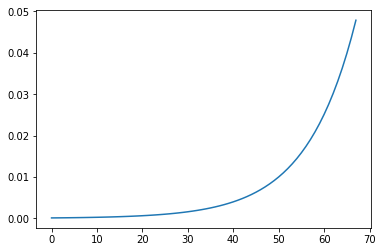

In [83]:
run.recorder.plot_lr()

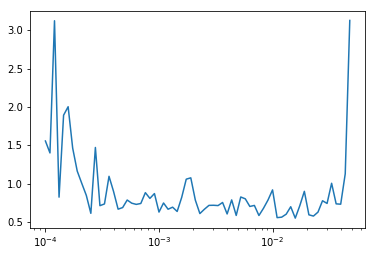

In [84]:
run.recorder.plot()

In [105]:
#sched = combine_scheds([0.1, 0.9], [sched_cos(2e-4, 2e-4), sched_cos(2e-4, 1e-7)])
sched =sched_exp(1e-4,1e-7)
cbfs = [Recorder,
        partial(AvgStatsCallback,accuracy),
       partial(ParamScheduler, 'lr', sched), CudaCallback]
learn = create_learner(get_model_func, loss_func, Data)

#freeze_to(learner=learn,layerNum=2)
run = Runner(cb_funcs=cbfs)

In [106]:
run.fit(10,learn)
#run.fit(50,learn)

train: [0.975127081313395, tensor(0.5173, device='cuda:0')]
valid: [0.6569374084472657, tensor(0.6750, device='cuda:0')]
train: [0.6856197093153341, tensor(0.5716, device='cuda:0')]
valid: [0.6414562861124674, tensor(0.6750, device='cuda:0')]
train: [0.6472047792129698, tensor(0.6247, device='cuda:0')]
valid: [0.629955800374349, tensor(0.6333, device='cuda:0')]
train: [0.6304040876948463, tensor(0.6372, device='cuda:0')]
valid: [0.6160483042399089, tensor(0.6750, device='cuda:0')]
train: [0.6146525744891109, tensor(0.6623, device='cuda:0')]
valid: [0.6126683553059896, tensor(0.6833, device='cuda:0')]
train: [0.6244505379251193, tensor(0.6617, device='cuda:0')]
valid: [0.6102088928222656, tensor(0.6833, device='cuda:0')]
train: [0.6251857275041021, tensor(0.6700, device='cuda:0')]
valid: [0.6113025665283203, tensor(0.6833, device='cuda:0')]
train: [0.6028356438320406, tensor(0.6748, device='cuda:0')]
valid: [0.610864766438802, tensor(0.6833, device='cuda:0')]
train: [0.5933449683724269,

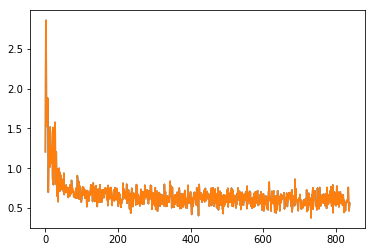

In [107]:
run.recorder.plot_loss()

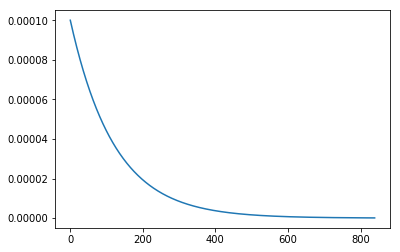

In [108]:
run.recorder.plot_lr()

In [142]:
class SaveActivations():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output.data.cpu()
    def remove(self): self.hook.remove()
        
class SaveGradients():
    features=None
    def __init__(self, m): self.hook = m.register_backward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features =output[0].data.cpu()
    def remove(self): self.hook.remove()

In [143]:
learn.model

MRNet3d(
  (conv1): convLayerBn(
    (conv): Conv3d(1, 32, kernel_size=(7, 7, 7), stride=(2, 2, 2), padding=(3, 3, 3), bias=False)
    (bn): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): LeakyReLU(negative_slope=0.1, inplace)
  )
  (resl1): resLayer(
    (conv1): convLayerBn(
      (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): LeakyReLU(negative_slope=0.1, inplace)
    )
    (conv2): convLayerBn(
      (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): LeakyReLU(negative_slope=0.1, inplace)
    )
  )
  (conv2): convLayerBn(
    (conv): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 2, 2), padding=(1, 1, 1), bias=False)
    (bn): BatchNorm3

In [144]:
#feature_layer = learn.model._modules.get('model')[0][-3]

In [148]:
feature_layer = learn.model._modules.get('resl3')

In [149]:
feature_layer

resLayer(
  (conv1): convLayerBn(
    (conv): Conv3d(50, 50, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    (bn): BatchNorm3d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): LeakyReLU(negative_slope=0.1, inplace)
  )
  (conv2): convLayerBn(
    (conv): Conv3d(50, 50, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    (bn): BatchNorm3d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): LeakyReLU(negative_slope=0.1, inplace)
  )
)

In [150]:
activated_features = SaveActivations(feature_layer)
gradient_features = SaveGradients(feature_layer)


In [151]:
m = learn.model.eval()

In [152]:
m

MRNet3d(
  (conv1): convLayerBn(
    (conv): Conv3d(1, 32, kernel_size=(7, 7, 7), stride=(2, 2, 2), padding=(3, 3, 3), bias=False)
    (bn): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): LeakyReLU(negative_slope=0.1, inplace)
  )
  (resl1): resLayer(
    (conv1): convLayerBn(
      (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): LeakyReLU(negative_slope=0.1, inplace)
    )
    (conv2): convLayerBn(
      (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): LeakyReLU(negative_slope=0.1, inplace)
    )
  )
  (conv2): convLayerBn(
    (conv): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 2, 2), padding=(1, 1, 1), bias=False)
    (bn): BatchNorm3

In [153]:
ds = valid_dataset[0][0]
ds = ds[None,...]
ds.shape

torch.Size([1, 1, 50, 64, 64])

In [154]:
prediction = m(ds.to(device))


In [155]:
prediction.shape

torch.Size([2])

In [156]:
prediction[0], prediction[1]

(tensor(0.0818, device='cuda:0', grad_fn=<SelectBackward>),
 tensor(-0.0881, device='cuda:0', grad_fn=<SelectBackward>))

In [157]:
valid_dataset[0][1].numpy()

array(0)

In [158]:
prediction[1]

tensor(-0.0881, device='cuda:0', grad_fn=<SelectBackward>)

In [159]:
prediction[0].backward()

In [160]:
activations = activated_features.features

In [161]:
activations.shape

torch.Size([1, 50, 25, 8, 8])

In [162]:
gradients=gradient_features.features

In [163]:
gradients.shape

torch.Size([1, 50, 25, 8, 8])

In [164]:
pooledGradient = gradients.mean(-1).mean(-1)



In [165]:
pooledGradient.shape

torch.Size([1, 50, 25])

In [166]:
heatmap = torch.mean(activations, dim=1).squeeze()

In [167]:
heatmap = np.maximum(heatmap, 0)
heatmap /= torch.max(heatmap)


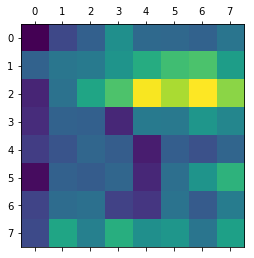

In [168]:
plt.matshow(heatmap[2,:,:].squeeze())

In [256]:
#export
eps = 1e-5
def show_batch_Index(learner, valid_ds,index,label= 1, heatmap = True):
    
    #learner.model.train()
    xs,ys = valid_ds[index][0], valid_ds[index][1]
    xs= xs[None]
    #xs = (xs - xs.min()) / (xs.max() - xs.min())
    #print (xs.shape)
    #ys = valid_ds[index][1]
    
    m = learner.model.eval()
    feature_layer =learner.model._modules.get('resl3') 
    activated_features = SaveActivations(feature_layer)
    gradient_features = SaveGradients(feature_layer)
    
    prediction = m(xs.to(device))
    prediction[label].backward()
    activations = activated_features.features
    gradients=gradient_features.features    
    pooledGradient = gradients.mean(-1).mean(-1)
    
    
    
    
    #print(pooledGradient.shape, pooledGradient[0].shape, activations.shape,  activations.shape[2])
    #print(pooledGradient[0])
    numFilters = activations.shape[2]
    
    
    
    
    for i in range(numFilters):
        activations[:,:, i, :, :] *= pooledGradient[:,:,i,None,None]
    
    activated_features.remove()
    gradient_features.remove()
    
    print (activations.shape, numFilters)
   
    heatmap = torch.sum(activations,dim=2).squeeze()
    #heatmap = np.maximum(heatmap, 0)
    
    
    F.relu_(heatmap)
    
    
   
    totalImages = xs.shape[2]
    print(totalImages, heatmap.shape)
    for imgIndex in range(totalImages):
        #print ( torch.max(heatmap[imgIndex,:,:]), torch.min(heatmap[imgIndex,:,:]))
        #if (torch.max(heatmap[imgIndex,:,:]) > 0):
        heatmap[imgIndex,:,:] = (heatmap[imgIndex,:,:] - torch.min(heatmap[imgIndex,:,:])) / (torch.max(heatmap[imgIndex,:,:]) - torch.min(heatmap[imgIndex,:,:])+eps) 
    #print(totalImages)
    totalImagesCols = 4
    totalImagesRows =totalImages//totalImagesCols
        
    axs = subplots(totalImagesRows, totalImagesCols, imgsize=4, figsize=(4*totalImagesCols,3*totalImagesRows))
    #denormalize for purpose of display
    xs = (xs - xs.min()) / (xs.max() - xs.min())
    xs = xs.squeeze()
    for imgIndex,ax in zip(range(totalImages),axs.flatten()):
        
        
      
        
        disp = xs[imgIndex,...].numpy()
        
        sz = list(disp.shape[-2:])
        #disp = disp.permute(1,2,).numpy()
        ax.imshow(disp,cmap='gray')
        ax.imshow(heatmap[imgIndex,:,:], alpha=0.4, extent=(0,*sz[::-1],0), interpolation='bilinear', cmap='magma')  
    plt.tight_layout()

In [257]:
valid_dataset[0][0].shape

torch.Size([1, 50, 64, 64])

torch.Size([1, 50, 25, 8, 8]) 25
50 torch.Size([50, 8, 8])


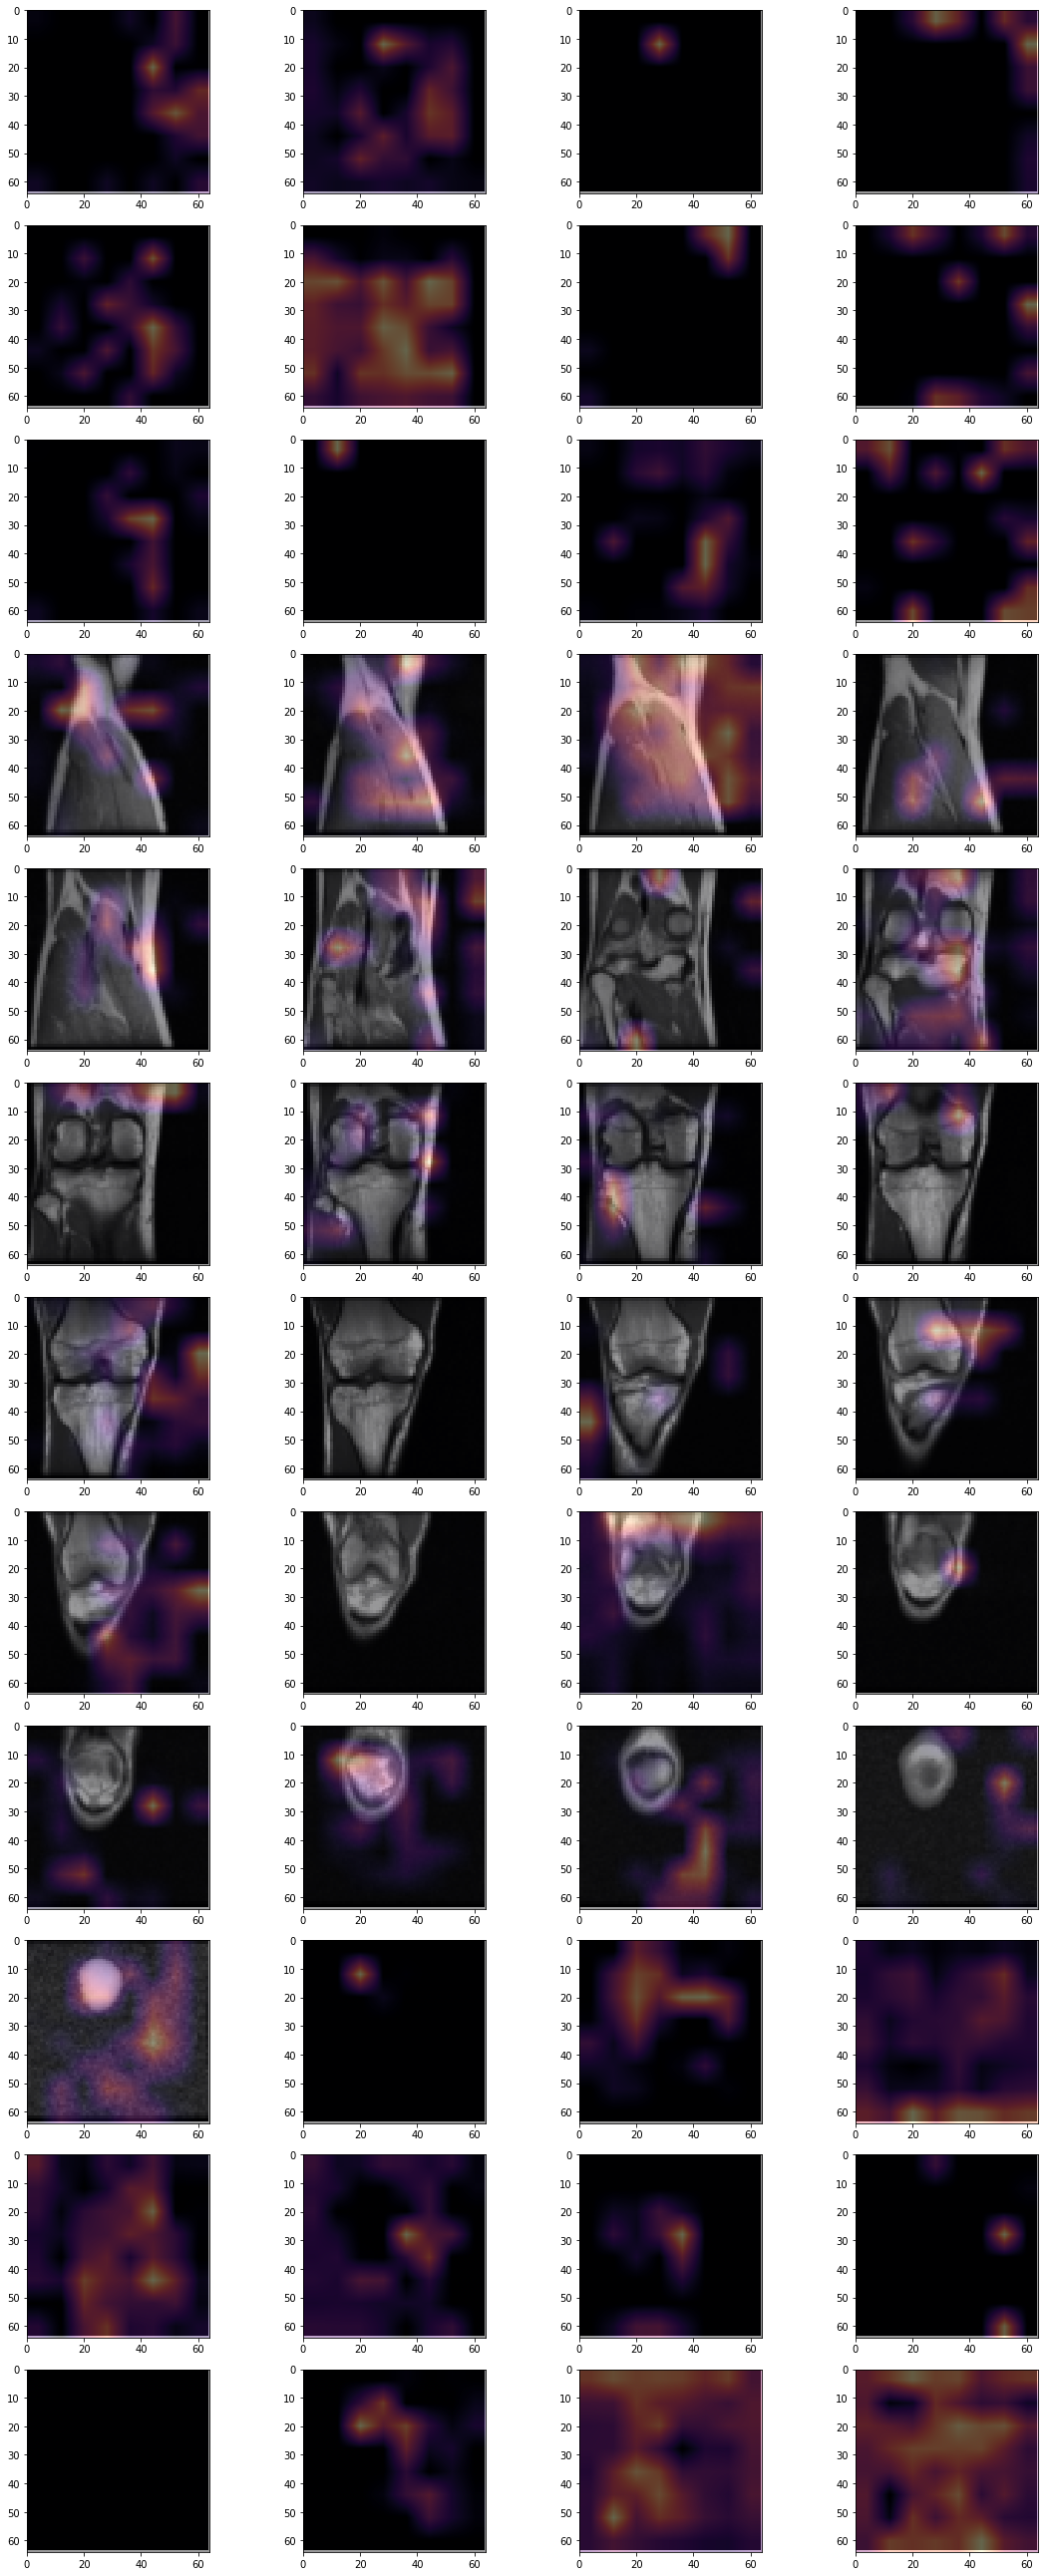

In [259]:
show_batch_Index(learn,valid_dataset,0,label=0)

In [ ]:
show_batch_Index(learn,valid_dataset,0,label=0)

In [ ]:
#export
def validate():  
    #model.to(device)
    valid_losses,predictions,truth = [],[],[]
    learn.model.eval()
    valid_losses_t = torch.zeros(2,20)
    with torch.no_grad():
        
        for xb, yb in learn.data.valid_dl:
            xb = xb.to(device)
            yb = yb.to(device)
            
            preds = learn.model(xb)
            
            if valid_losses_t.shape[0] == 2 :
                valid_losses_t = loss_func(preds,yb)
                print(valid_losses_t.shape)
            else:
                valid_losses_t = torch.stack((valid_losses_t,loss_func(preds,yb).cpu()),0)
            #valid_losses.append(loss_func(preds,yb))
            #truth.append(torch.squeeze(yb))
            #predictions.append(torch.squeeze(torch.sigmoid(preds)))
    print (valid_losses_t)
            
            
    #return torch.stack(valid_losses).cpu(), torch.stack(predictions).cpu(), torch.stack(truth).cpu()

In [ ]:
#val_losses1, preds,truthVal = validate()
validate()

In [ ]:
fpr, tpr, threshold = metrics.roc_curve(truthVal, torch.argmax(preds, dim=1))
auc = metrics.auc(fpr, tpr)

In [ ]:
fpr

In [ ]:
tpr

In [ ]:
threshold

In [ ]:
auc

In [ ]:
#plt.figure()
#lw = 2
#plt.plot(fpr, tpr[2], color='darkorange',
#         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])

In [ ]:
val_losses1, preds, truthVal

In [ ]:
total_subjects = len (valid_dataset)

In [ ]:
TruthPositive = truthVal.sum().numpy()
TruthNegative = total_subjects - TruthPositive
binaryPreds = torch.argmax(preds, dim=1)

In [ ]:
total_subjects,TruthPositive, TruthNegative, binaryPreds

In [ ]:
top3losses,top3lossesIndex = val_losses1.topk(3,largest=True)

In [ ]:
top3losses, top3lossesIndex

In [ ]:
bottom3losses, bottom3lossesIndex = val_losses1.topk(3,largest=False)

In [ ]:
bottom3losses,bottom3lossesIndex

In [ ]:
show_batch_Index(learn,valid_dataset,top3lossesIndex[0],valid_dataset[top3lossesIndex[0]][1])

In [ ]:
show_batch_Index(learn,valid_dataset,bottom3lossesIndex[0],valid_dataset[bottom3lossesIndex[0]][1])

In [ ]:
#!python 'notebook2script.py' '02_BasicTrainingLoop.ipynb'